# Detection of Negative Reviews in Classic Movies

Film Junky Union, a cutting-edge community for classic movie enthusiasts, is developing a system to filter and categorize film reviews. Your goal is to train a model to automatically detect negative reviews. To achieve this, you will use a dataset of movie reviews from IMDB with polarity labels to build a model that classifies positive and negative reviews. This model should achieve an F1 score of at least 0.85.

Here are the selected fields:

- `review`: Text of the review.
- `pos`: Target ('0' for negative and '1' for positive).
- `ds_part`: 'train'/'test' for the training/testing part of the dataset, respectively.

# Initialization

In [1]:
# Load libraries

# Data manipulation
import math
import re
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Modeling
import torch
import transformers
import spacy
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn.metrics as metrics

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Settings
%matplotlib inline
%config InlineBackend.figure_format = 'png'
tqdm.pandas()

In [3]:
# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Download spacy model
spacy.cli.download("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 81.2 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Load data

In [5]:
# Load the data into DataFrames
df_reviews = pd.read_csv('/kaggle/input/imdb-reviews/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## Preparación de datos

In [6]:
# Print the general/summary information about the DataFrames
df_reviews.info()

# Print a random sample of 5 rows from the DataFrame
df_reviews.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22360,tt0043809,movie,Miracle in Milan,Miracolo a Milano,1951,\N,97,0,"Comedy,Drama,Fantasy",7.7,6106,This obscure de Sica delivers the goods. And i...,10,pos,1,train,3660
7983,tt0337945,movie,Coronado,Coronado,2003,\N,88,0,"Action,Adventure,Comedy",4.4,1472,"Infamous for being ""brought to you by the digi...",1,neg,0,test,4793
22781,tt0300214,movie,Morvern Callar,Morvern Callar,2002,\N,97,0,Drama,6.8,8940,There are a lot of pretentious people out ther...,1,neg,0,train,10295
15641,tt0077651,movie,Halloween,Halloween,1978,\N,91,0,"Horror,Thriller",7.8,220534,Halloween is a film I have to get out and watc...,9,pos,1,train,7311
1301,tt0070795,movie,A Thief in the Night,A Thief in the Night,1972,\N,69,0,"Drama,Fantasy,Horror",4.8,661,"Obviously, there wasn't a huge budget for this...",7,pos,1,train,11705


## Intermediate Conclusion

Although none of the columns contain missing values, the data type in some of them indicates that there could actually be missing data represented by `string` values. It will be necessary to perform an exploratory analysis focusing on the selected columns to determine if these values are present in these columns.

# EDA

## Number of movies and reviews over the years

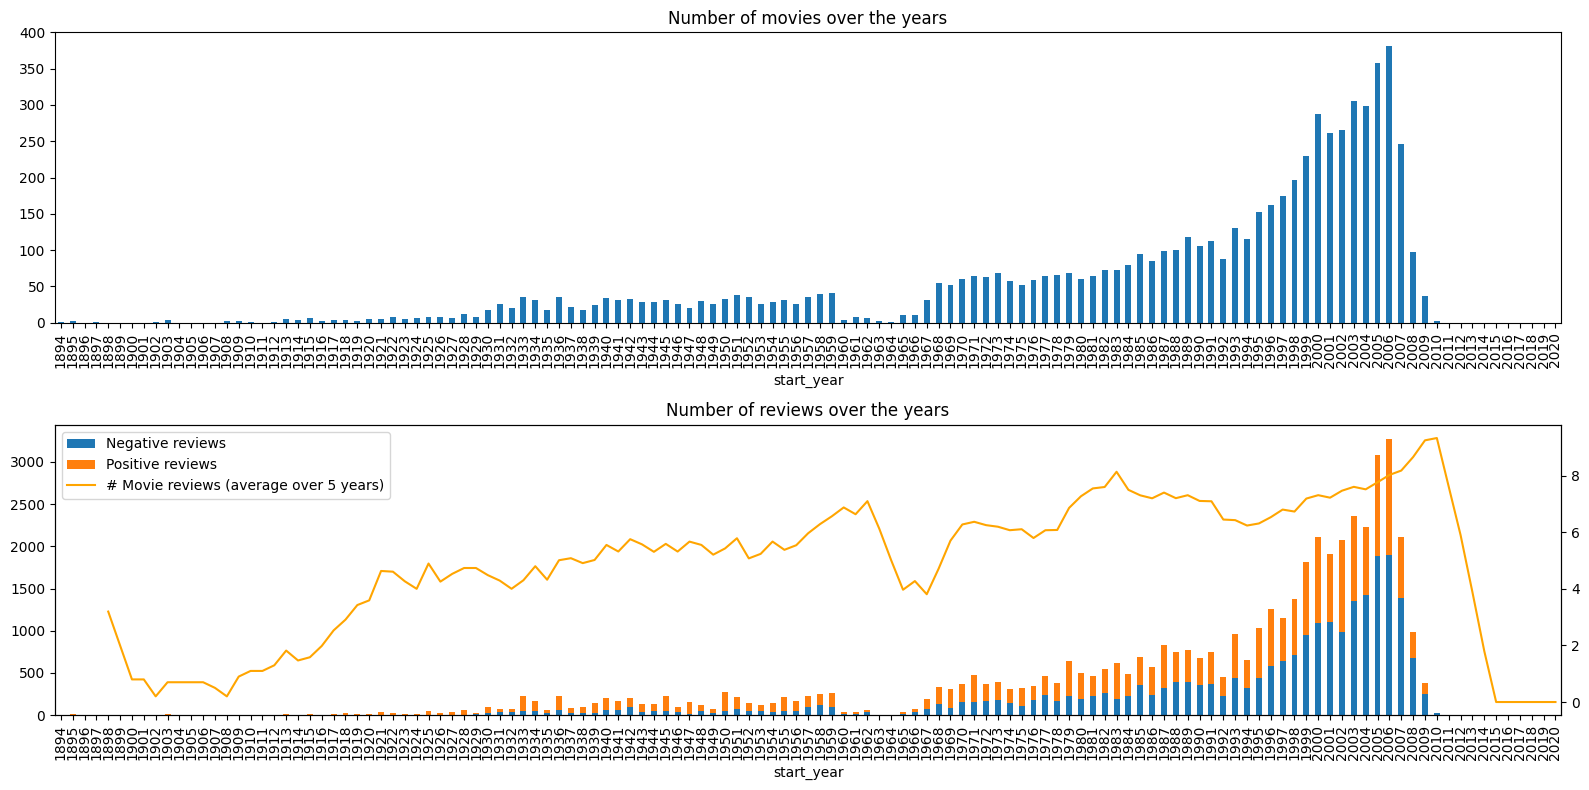

In [7]:
# Create bar charts for the number of movies and reviews over the years
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of movies over the years')

ax = axs[1]
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0).rename(columns={0: 'Negative reviews', 1: 'Positive reviews'})
dft2.plot(kind='bar', stacked=True, ax=ax)
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='# Movie reviews (average over 5 years)', ax=axt)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = axt.get_legend_handles_labels()
lines, labels = lines1 + lines2, labels1 + labels2
ax.legend(lines, labels, loc='upper left')
ax.set_title('Number of reviews over the years')

fig.tight_layout()

## Distribution of the number of reviews per movie with exact count and KDE

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


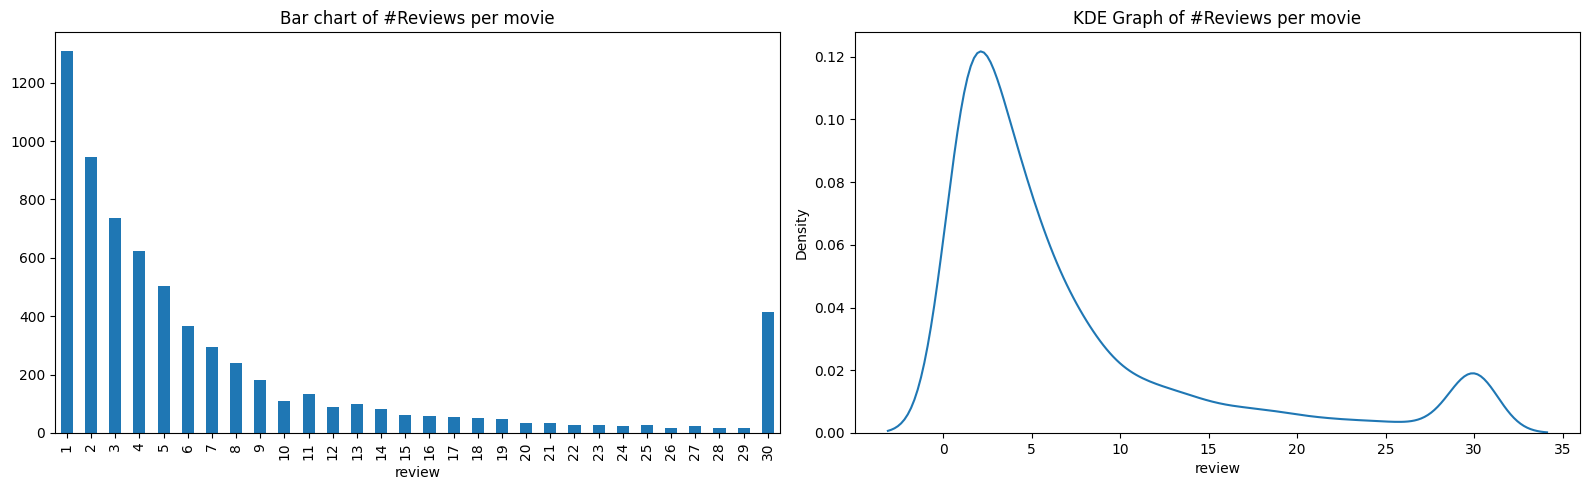

In [8]:
# Create a bar chart and KDE for the number of reviews per movie
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count().value_counts().sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar chart of #Reviews per movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Graph of #Reviews per movie')

fig.tight_layout()

## Distribution of scores in the training and test sets

In [9]:
# Print the number of reviews on train and test sets
df_reviews['ds_part'].value_counts()

ds_part
train    23796
test     23535
Name: count, dtype: int64

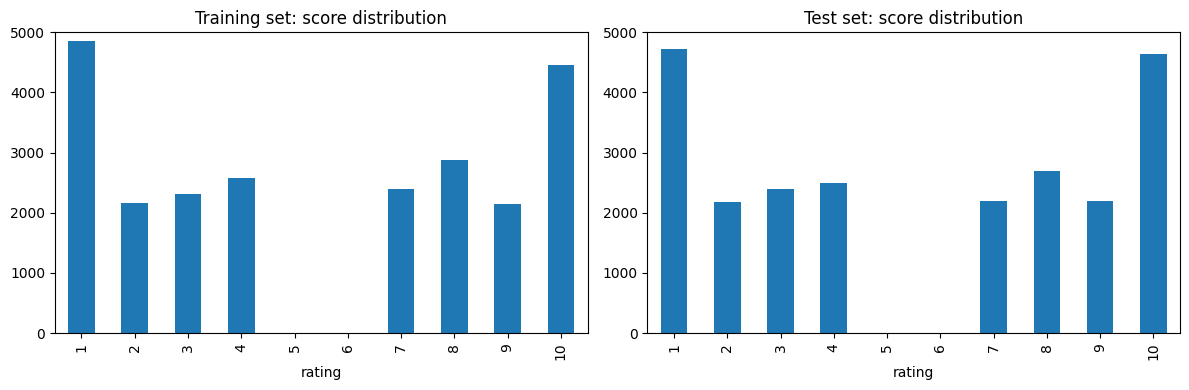

In [10]:
# Create bar charts for the distribution of scores in the training and test sets
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Training set: score distribution')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: score distribution')

fig.tight_layout()

## Distribution of reviews with different polarities by year and movie in the training and test sets

In [11]:
# Show distribution of positive and negative reviews
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

## Intermediate conclusion

- The number of movies over the years has significantly increased, while the number of reviews only slightly increased.
- The number of reviews per movie varies greatly depending on the movie.
- Ratings show a tendency towards polarization, as the distribution is higher at the extreme values.

For the three selected columns (`review`, `pos`, `ds_part`):
- There doesn't seem to be any issue with missing values.
- The data type is correct.
- The distribution of polarities in the train and test sets is very similar.


# Evaluation

In [12]:
# Create function to evaluate several models
def evaluate_model(model, train_features, train_target, test_features, test_target):
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Plot
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')     
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title('F1 Value')

        # ROC AUC Plot
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')      
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title('ROC Curve')
        
        # PRC Plot
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}') 
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

# Normalization

In [13]:
# Create function to normalize the text
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [14]:
# Normalize the text
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)
df_reviews[['review', 'review_norm']].sample(5)

,review,review_norm
521,"While sleeping, Mr. Eko is assigned by his bro...",while sleeping mr eko is assigned by his broth...
34893,The name of this film and the clips that I saw...,the name of this film and the clips that i saw...
27303,And I really mean that. I caught it last night...,and i really mean that i caught it last night ...
7604,This movie really has nothing going for it. W...,this movie really has nothing going for it wit...
236,"Having not read the novel, I can't tell how fa...",having not read the novel i can t tell how fai...


# Training / Testing Split

In [15]:
# Split into train and test sets
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [16]:
# Get a sample of the training and test sets to reduce training time
sample_size = 3000
df_reviews_train_sample = df_reviews_train.sample(sample_size, random_state=12345).copy()
df_reviews_test_sample = df_reviews_test.sample(sample_size, random_state=12345).copy()

In [17]:
# Get train and test target
train_target = df_reviews_train_sample['pos']
test_target = df_reviews_test_sample['pos']

# Modeling

## Model 0 - Constant

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


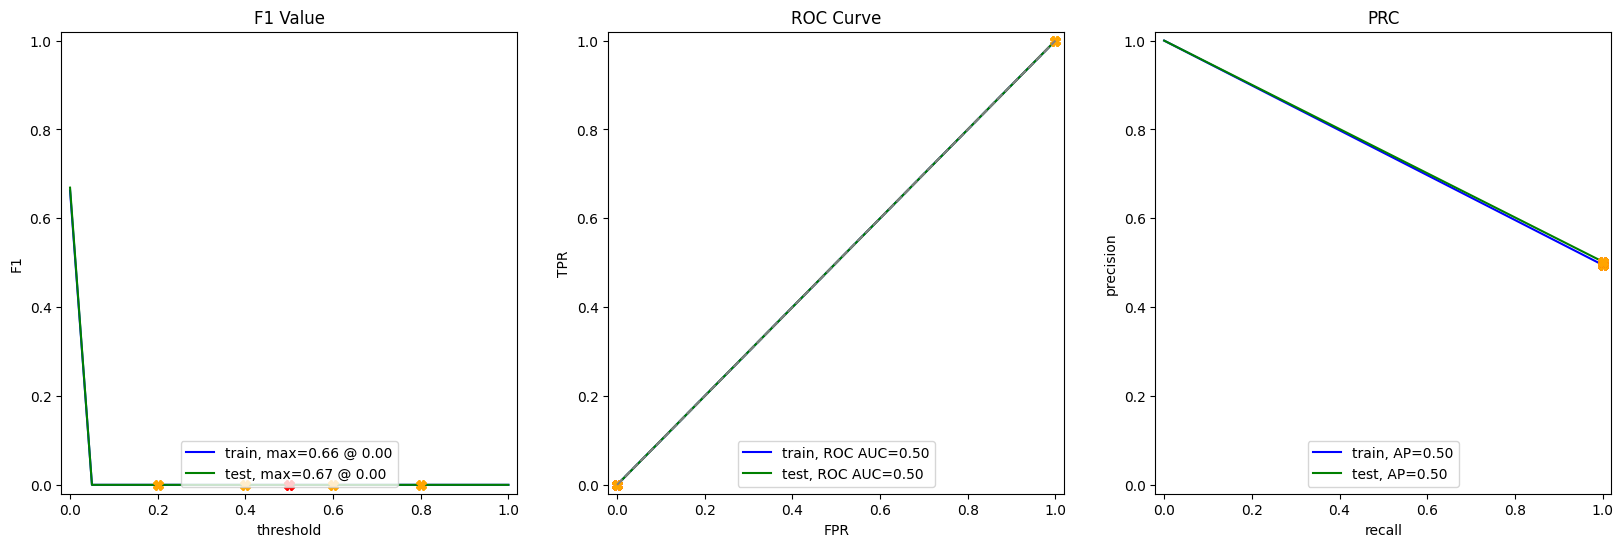

In [18]:
# Get train and test features
vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform(df_reviews_train_sample['review_norm'])
test_features = vectorizer.transform(df_reviews_test_sample['review_norm'])

# DummyClassifier
dummy = DummyClassifier(strategy='most_frequent', random_state=12345)
dummy.fit(train_features, train_target)

# Evaluate model
evaluate_model(dummy, train_features, train_target, test_features, test_target)

## Model 1 - NLTK, TF-IDF and LR

          train  test
Accuracy   0.96  0.84
F1         0.96  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


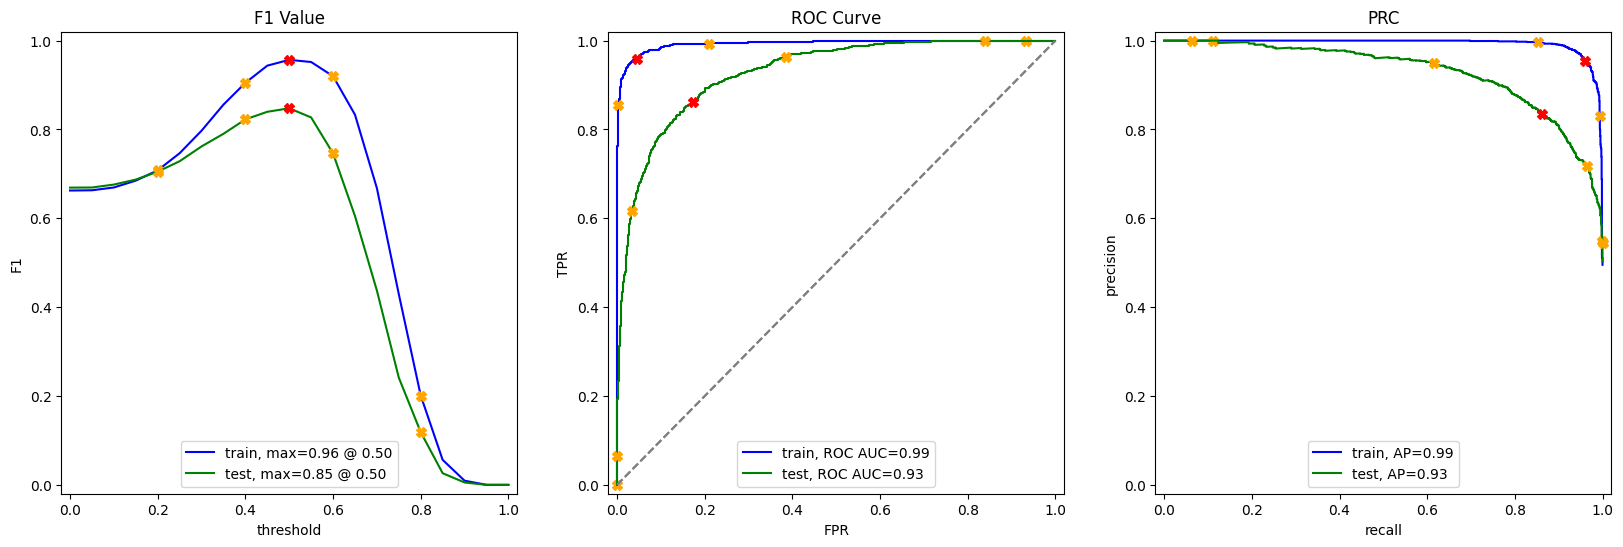

In [19]:
# Get train and test features
count_tf_idf_1 = TfidfVectorizer(stop_words=list(set(nltk_stopwords.words('english'))))
count_tf_idf_1.fit(df_reviews_train['review_norm'])
train_features = count_tf_idf_1.transform(df_reviews_train_sample['review_norm'])
test_features = count_tf_idf_1.transform(df_reviews_test_sample['review_norm'])

# LogisticRegression
logreg_1 = LogisticRegression(random_state=12345)
logreg_1.fit(train_features, train_target)

# Evaluate model
evaluate_model(logreg_1, train_features, train_target, test_features, test_target)

## Model 2 - spaCy, TF-IDF and LR

In [20]:
# Create Spacy instance
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Create function to lemmatize the text
def lemmatize(text):
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

In [21]:
# Lemmatize the text and save it in a new column
df_reviews_train_sample['review_lemma'] = df_reviews_train_sample['review_norm'].apply(lemmatize)
df_reviews_test_sample['review_lemma'] = df_reviews_test_sample['review_norm'].apply(lemmatize)
df_reviews_train_sample[['review', 'review_norm', 'review_lemma']].head(5)

,review,review_norm,review_lemma
14148,Who? What? Where? When? Why? The acting was te...,who what where when why the acting was terribl...,who what where when why the acting be terrible...
40229,THE NOTORIOUS BETTIE PAGE Written by Mary Harr...,the notorious bettie page written by mary harr...,the notorious bettie page write by mary harron...
38690,It is not as great a film as many people belie...,it is not as great a film as many people belie...,it be not as great a film as many people belie...
13231,When I saw this trailer on TV I was surprised....,when i saw this trailer on tv i was surprised ...,when I see this trailer on tv I be surprised i...
28023,"As others have commented, I checked this out a...",as others have commented i checked this out af...,as other have comment I check this out after s...


          train  test
Accuracy   0.95  0.85
F1         0.95  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


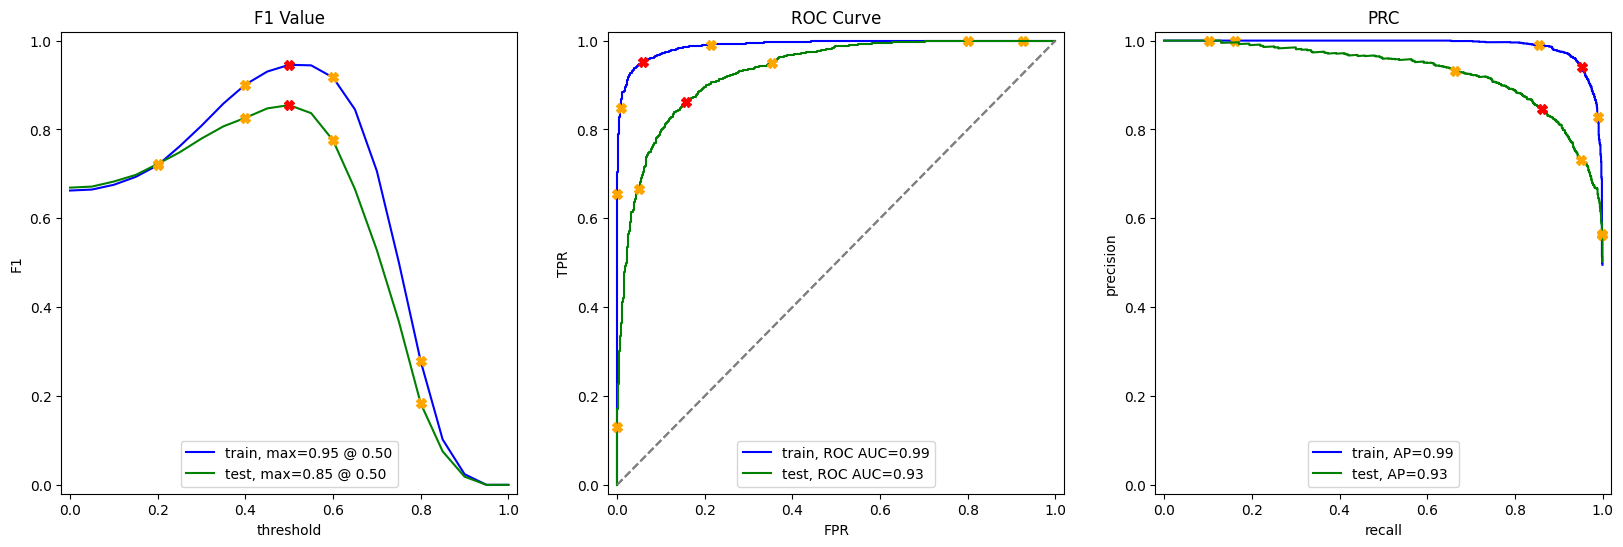

In [22]:
# Get train and test features with lemmatized text
count_tf_idf_2 = TfidfVectorizer(stop_words=list(set(nltk_stopwords.words('english'))))
count_tf_idf_2.fit(df_reviews_train_sample['review_lemma'])
train_features_lemma = count_tf_idf_2.transform(df_reviews_train_sample['review_lemma'])
test_features_lemma = count_tf_idf_2.transform(df_reviews_test_sample['review_lemma'])

# LogisticRegression
logreg_2 = LogisticRegression(random_state=12345)
logreg_2.fit(train_features_lemma, train_target)

# Evaluate model
evaluate_model(logreg_2, train_features_lemma, train_target, test_features_lemma, test_target)

## Model 3 - BERT

In [23]:
# Initialize the tokenizer, model, and BERT configuration
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [28]:
# Create function to get BERT embeddings
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    tokenized_texts = texts.apply(
        lambda x: 
        tokenizer.encode(
            x.lower(),
            add_special_tokens=True,
            truncation=True,
            max_length=max_length
        )
    )
    
    for ids in tokenized_texts:
        padded = np.array(ids[:max_length] + [0]*(max_length - len(ids)))
        ids_list.append(padded)
        attention_mask_list.append(np.where(padded != 0, 1, 0))
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Device {device}')

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [29]:
# Get train and test features with BERT embeddings
train_features_bert = BERT_text_to_embeddings(df_reviews_train_sample['review_norm'])
test_features_bert = BERT_text_to_embeddings(df_reviews_test_sample['review_norm'])

Device cuda


  0%|          | 0/30 [00:00<?, ?it/s]

Device cuda


  0%|          | 0/30 [00:00<?, ?it/s]

In [30]:
# Save BERT train and test features
np.savez_compressed('/kaggle/working/features_bert.npz', train_features_bert=train_features_bert, test_features_bert=test_features_bert)

# Load BERT train and test features
with np.load('/kaggle/working/features_bert.npz') as data:
    train_features_bert = data['train_features_bert']
    test_features_bert = data['test_features_bert']

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          train  test
Accuracy   0.92  0.82
F1         0.91  0.82
APS        0.97  0.90
ROC AUC    0.97  0.90


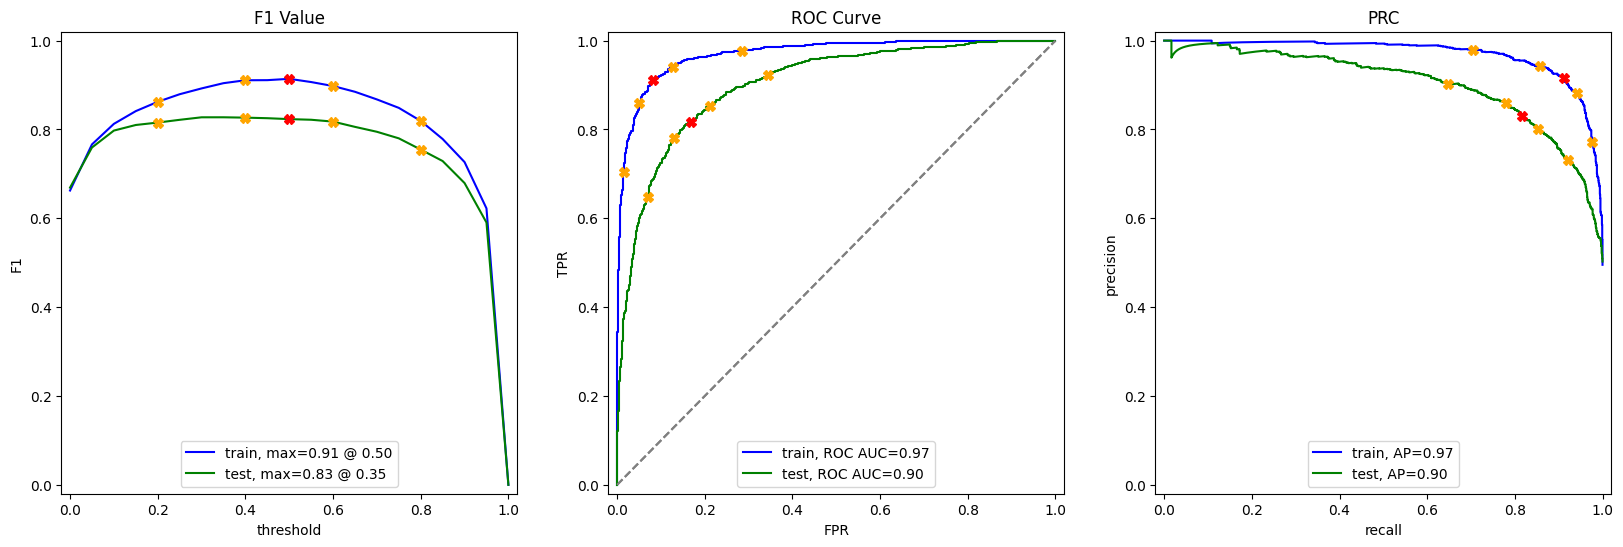

In [31]:
# LogisticRegression
logreg_3 = LogisticRegression(random_state=12345)
logreg_3.fit(train_features_bert, train_target)

# Evaluate model
evaluate_model(logreg_3, train_features_bert, train_target, test_features_bert, test_target)

## Intermediate conclusion

- `Model 0 - Constant`: Acts as a baseline, always predicts the same and has an F1 score of 0. Its Accuracy, APS, and ROC AUC are all 0.5, indicating random predictions.

- `Model 1 - NLTK, TF-IDF, and LR`: This model performs similarly to Model 2. With scores close to 0.9 in tests, the combination of NLTK, TF-IDF, and logistic regression produces a robust model.

- `Model 2 - spaCy, TF-IDF, and LR`: Performance is practically identical to Model 1; this suggests that both NLTK and spaCy have similar capabilities when used with TF-IDF and logistic regression in this context.

- `Model 3 - BERT`: Although it still slightly lags behind Models 1 and 2 in tests, its ability to capture complex contexts stands out. With further optimization, BERT could offer even better performance.


# My reviews

In [32]:
# Create a set of movie reviews to test the models
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# Normalize text
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

# Show the result of text normalization
my_reviews[['review', 'review_norm']].sample(5)

# Save the normalized text for later use
texts = my_reviews['review_norm']

## Test Model 0 - Constant

In [33]:
# Get predictions with the DummyClassifier
my_reviews_pred_prob = dummy.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.00:  i did not simply like it not my kind of movie
0.00:  well i was bored and felt asleep in the middle of the movie
0.00:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.00:  i didn t expect the reboot to be so good writers really cared about the source material
0.00:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.00:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.00:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Test Model 1 - NLTK, TF-IDF and LR

In [34]:
# Get predictions with Model 1 - NLTK, TF-IDF, and LR
my_reviews_pred_prob = logreg_1.predict_proba(count_tf_idf_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.30:  i did not simply like it not my kind of movie
0.43:  well i was bored and felt asleep in the middle of the movie
0.43:  i was really fascinated with the movie
0.33:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.47:  i didn t expect the reboot to be so good writers really cared about the source material
0.44:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.33:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.68:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Test Model 2 - spaCy, TF-IDF and LR

In [35]:
# Get predictions with Model 2 - spaCy, TF-IDF, and LR
my_reviews_pred_prob = logreg_2.predict_proba(count_tf_idf_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.35:  i did not simply like it not my kind of movie
0.47:  well i was bored and felt asleep in the middle of the movie
0.46:  i was really fascinated with the movie
0.38:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.51:  i didn t expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.32:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.79:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Test Model 3 - BERT

In [36]:
# Get predictions with model 3 - BERT
my_reviews_features_bert = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = logreg_3.predict_proba(my_reviews_features_bert)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.47:  i did not simply like it not my kind of movie
0.00:  well i was bored and felt asleep in the middle of the movie
0.89:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.46:  i didn t expect the reboot to be so good writers really cared about the source material
0.91:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.16:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.98:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Intermediate conclusion

Setting aside the results from the Dummy model, there is a strong similarity between models 1 and 2. Both models, in general terms, are aligned in their classification but with nuances in their level of confidence. Model 2 tends to be slightly more optimistic in its classification, which can be either useful or problematic depending on the application. If avoiding false negatives is desired (for example, in a context where highlighting most positive comments is important), Model 2 might be more suitable. On the other hand, if being more conservative and avoiding false positives is preferred, Model 1 could be the better choice.

Regarding model 3 (BERT), it demonstrates its ability to capture complex contexts and nuances in language by providing highly confident classifications in most cases. Extreme predictions (close to 0 or 1) showcase the model's confidence in its decision, while intermediate predictions reflect text ambiguity or complexity. Despite its performance, it's essential to consider the computational cost associated with using models like BERT; however, if precision and deep contextual understanding are sought after, BERT is an excellent choice.

# General Conclusion

Throughout this study on movie review classification:

1. We conducted an initial analysis of the reviews, focusing on the sentiment of each one. To facilitate handling, we limited our dataset to `3000` records.

2. We deployed and compared different natural language processing techniques (`NLTK, TF-IDF with LR`, `spaCy, TF-IDF with LR`, and `BERT`) in order to categorize the polarity of movie reviews.

3. We incorporated advanced features such as embeddings and vectorizations.

4. Although NLTK and spaCy models with TF-IDF and LR showed similar results in testing, it was the `BERT` model that stood out for its ability to distinguish complex contexts and nuances in the reviews, despite higher computational cost.

With what can be concluded that:

- `Dummy Model`: As a baseline model, it always predicted the same class. Its F1 score of 0 and APS and ROC AUC of 0.5 confirm that it simply acts as a random prediction generator and does not provide value in terms of classification.

- `NLTK and spaCy with TF-IDF and LR`: Both Model 1 and Model 2 demonstrated similar and robust performance in classification, with scores close to 0.9 on tests. The similarity between these models indicates that, for this dataset and context, `NLTK` and `spaCy` offer comparable capabilities when combined with `TF-IDF` and `logistic regression`. However, it is important to consider their nuances: while Model 1 tends to be more conservative in its predictions, Model 2 shows a slightly more optimistic inclination.

- `BERT`: Model 3 illustrates the ability of deep language models to capture complex contexts in reviews. Not only does BERT provide predictions with high confidence, but it also reflects the inherent ambiguity in some texts; it could even outperform other models in terms of performance.

While conventional models (`NLTK` and `spaCy` with `TF-IDF`and `LR`) offer a quick and robust solution for classification, BERT emerges as a powerful tool for those seeking a more detailed and profound analysis of reviews albeit at higher computational cost. The final choice of model will depend on the balance between accuracy, interpretability, and efficiency desired to achieve.